In [ ]:
import numpy as np
import cv2
import sys
from skimage.morphology import disk
from skimage.filters import median

In [ ]:
def patch_ex(ima_dest, ima_src=None, same=False, num_patches=1,
             mode=cv2.NORMAL_CLONE, width_bounds_pct=((0.3,0.7),(0.3,0.7)), min_object_pct=0.25, 
             min_overlap_pct=0.25, shift=False, label_mode='continuous', skip_background=None, tol=1, resize=True,
             gamma_params=None, intensity_logistic_params=(1/6, 20),
             resize_bounds=(0.7, 1.3), verbose=True):
  ##### 비율 조정 - factor
    """
    Create a synthetic training example from the given images by pasting/blending random patches.
    Args:
        ima_dest (uint8 numpy array): image with shape (W,H,3) or (W,H,1) where patch should be changed
        ima_src (uint8 numpy array): optional, otherwise use ima_dest as source
        same (bool): use ima_dest as source even if ima_src given
        mode: 'uniform', 'swap', 'mix', cv2.NORMAL_CLONE, or cv2.MIXED_CLONE what blending method to use
             ('mix' is flip a coin between normal and mixed clone)
        num_patches (int): how many patches to add. the method will always attempt to add the first patch,
                    for each subsequent patch it flips a coin
        width_bounds_pct ((float, float), (float, float)): min half-width of patch ((min_dim1, max_dim1), (min_dim2, max_dim2))
        shift (bool): if false, patches in src and dest image have same coords. otherwise random shift
        resize (bool): if true, patch is resampled at random size (within bounds and keeping aspect ratio the same) before blending  
        skip_background (int, int) or [(int, int),]: optional, assume background color is first and only interpolate patches
                    in areas where dest or src patch has pixelwise MAD < second from background.
        tol (int): mean abs intensity change required to get positive label
        gamma_params (float, float, float): optional, (shape, scale, left offset) of gamma dist to sample half-width of patch from,
                    otherwise use uniform dist between 0.05 and 0.95
        intensity_logistic_params (float, float): k, x0 of logitistc map for intensity based label
        label_mode: 'binary', 
                    'continuous' -- use interpolation factor as label (only when mode is 'uniform'),
                    'intensity' -- use median filtered mean absolute pixelwise intensity difference as label,
                    'logistic-intensity' -- use logistic median filtered of mean absolute pixelwise intensity difference as label,
    """
    if mode == 'mix':
        mode = (cv2.NORMAL_CLONE, cv2.MIXED_CLONE)[np.random.randint(2)]
    ima_src = ima_dest.copy() if same or (ima_src is None) else ima_src

    if skip_background is not None:
        if isinstance(skip_background, tuple):
            skip_background = [skip_background]
        src_object_mask = np.ones_like(ima_src[...,0:1])
        dest_object_mask = np.ones_like(ima_dest[...,0:1])
        for background, threshold in skip_background:
            src_object_mask &= np.uint8(np.abs(ima_src.mean(axis=-1, keepdims=True) - background) > threshold)  ### ima_src의 mean이 treshold보다 낮은 것
            dest_object_mask &= np.uint8(np.abs(ima_dest.mean(axis=-1, keepdims=True) - background) > threshold)
        src_object_mask[...,0] = cv2.medianBlur(src_object_mask[...,0], 7)  # remove grain from threshold choice
        dest_object_mask[...,0] = cv2.medianBlur(dest_object_mask[...,0], 7)  # remove grain from threshold choice  ### 흐리게 만들기
    else:
        src_object_mask = None
        dest_object_mask = None
    
    # add patches
    mask = np.zeros_like(ima_dest[..., 0:1])  # single channel
    patchex = ima_dest.copy()
    coor_min_dim1, coor_max_dim1, coor_min_dim2, coor_max_dim2 = mask.shape[0] - 1, 0, mask.shape[1] - 1, 0 ### patchex의 좌표 
    if label_mode == 'continuous':
        factor = np.random.uniform(0.3, 0.7)
        
        ##factor = np.random.uniform(0.05, 0.95)
    else:
        factor = 1
    for i in range(num_patches):
        if i == 0 or np.random.randint(2) > 0:  # at least one patch
            # patchex , t , label = _patch_ex(      ## patchex , 좌표값 가져오기 
            #     patchex, ima_src, dest_object_mask, src_object_mask, mode, label_mode, shift, resize, width_bounds_pct, 
            #     gamma_params, min_object_pct, min_overlap_pct, factor, resize_bounds, verbose)
            patchex, ((_coor_min_dim1, _coor_max_dim1), (_coor_min_dim2, _coor_max_dim2)), patch_mask = _patch_ex(      ## patchex , 좌표값 가져오기 
                patchex, ima_src, dest_object_mask, src_object_mask, mode, label_mode, shift, resize, width_bounds_pct, 
                gamma_params, min_object_pct, min_overlap_pct, factor, resize_bounds, verbose)
            # if patch_mask is not None:
            #     mask[_coor_min_dim1:_coor_max_dim1,_coor_min_dim2:_coor_max_dim2] = patch_mask
            coor_min_dim1 = min(coor_min_dim1, _coor_min_dim1) 
            coor_max_dim1 = max(coor_max_dim1, _coor_max_dim1) 
            coor_min_dim2 = min(coor_min_dim2, _coor_min_dim2)
            coor_max_dim2 = max(coor_max_dim2, _coor_max_dim2)

    # create label
    # label_mask = np.uint8(np.mean(np.abs(1.0 * mask*ima_dest - 1.0 * mask*patchex), axis=-1, keepdims=True) > tol)
    # label_mask[...,0] = cv2.medianBlur(label_mask[...,0], 5)  # remove grain from threshold choice

    # if label_mode == 'continuous':
    #     label = label_mask * factor
    # elif label_mode in ['logistic-intensity', 'intensity']:
    #     k, x0 = intensity_logistic_params
    #     label = np.mean(np.abs(label_mask * ima_dest * 1.0 - label_mask * patchex * 1.0), axis=-1, keepdims=True)
    #     label[...,0] = median(label[...,0], disk(5))
    #     if label_mode == 'logistic-intensity':
    #         label = label_mask / (1 + np.exp(-k * (label - x0)))
    # elif label_mode == 'binary':
    #     label = label_mask  
    # else:
    #     raise ValueError("label_mode not supported" + str(label_mode))

    return patchex,((_coor_min_dim1, _coor_max_dim1), (_coor_min_dim2, _coor_max_dim2)), factor


def _patch_ex(ima_dest, ima_src, dest_object_mask, src_object_mask, mode, label_mode, shift, resize, width_bounds_pct, 
              gamma_params, min_object_pct, min_overlap_pct, factor, resize_bounds, verbose):
    skip_background = False ##(src_object_mask is not None) and (dest_object_mask is not None)
    dims = np.array(ima_dest.shape)
    min_width_dim1 = (width_bounds_pct[0][0]*dims[0]).round().astype(int)   ### width_bounds_pct -> 패치 최소 크기
    max_width_dim1 = (width_bounds_pct[0][1]*dims[0]).round().astype(int)
    min_width_dim2 = (width_bounds_pct[1][0]*dims[1]).round().astype(int)
    max_width_dim2 = (width_bounds_pct[1][1]*dims[1]).round().astype(int)

    if gamma_params is not None:
        shape, scale, lower_bound = gamma_params
        #### numpy.clip(array, min, max) -> min보다 작은 값을 min으로, max보다 큰 값을 max로
        patch_width_dim1 = int(np.clip((lower_bound + np.random.gamma(shape, scale)) * dims[0], min_width_dim1, max_width_dim1))
        patch_width_dim2 = int(np.clip((lower_bound + np.random.gamma(shape, scale)) * dims[1], min_width_dim2, max_width_dim2))
    else:   ### patch의 크기설정
        patch_width_dim1 = np.random.randint(min_width_dim1, max_width_dim1)
        patch_width_dim2 = np.random.randint(min_width_dim2, max_width_dim2)

    found_patch = False
    attempts = 0
    while not found_patch:
        center_dim1 = np.random.randint(min_width_dim1, dims[0]-min_width_dim1) ### 중앙값?
        center_dim2 = np.random.randint(min_width_dim2, dims[1]-min_width_dim2)

        coor_min_dim1 = np.clip(center_dim1 - patch_width_dim1, 0, dims[0]) ## 좌표의 min, max값
        coor_min_dim2 = np.clip(center_dim2 - patch_width_dim2, 0, dims[1])
        coor_max_dim1 = np.clip(center_dim1 + patch_width_dim1, 0, dims[0])
        coor_max_dim2 = np.clip(center_dim2 + patch_width_dim2, 0, dims[1])

        patch_mask = np.ones((coor_max_dim1 - coor_min_dim1, coor_max_dim2 - coor_min_dim2, 1), dtype=np.uint8) ## 패치 크기만큼의 mask생성,

        if skip_background:
            background_area = np.sum(patch_mask & src_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2])
            found_patch = (background_area / (patch_mask.shape[0] * patch_mask.shape[1]) > min_object_pct) ### min_object_pct비율보다 background area비율이 높아야 패치를 찾은 것
        else:
            found_patch = True
        attempts += 1
        if attempts == 200:
            if verbose:
                print('No suitable patch found.')
            return ima_dest.copy(), ((0,0),(0,0)), None

    src = ima_src[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]
    
    height, width, _ = src.shape
    if resize:
        lb, ub = resize_bounds
        scale = np.clip(np.random.normal(1, 0.5), lb, ub)
        new_height = np.clip(scale * height, min_width_dim1, max_width_dim1)
        new_width = np.clip(int(new_height / height * width), min_width_dim2, max_width_dim2)
        new_height = np.clip(int(new_width / width * height), min_width_dim1, max_width_dim1)  # in case there was clipping
        if src.shape[2] == 1:  # grayscale
            src = cv2.resize(src[..., 0], (new_width, new_height))
            src = src[...,None]
        else:
            src = cv2.resize(src, (new_width, new_height))
        height, width, _ = src.shape
        patch_mask = cv2.resize(patch_mask[...,0], (width, height))
        patch_mask = patch_mask[...,None]
    
    if skip_background:
        src_object_mask = cv2.resize(src_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2, 0], (width, height))
        src_object_mask = src_object_mask[...,None]
    
    # sample destination location and size
    if shift:
        found_center = False
        attempts = 0
        while not found_center:
            center_dim1 = np.random.randint(height//2 + 1, ima_dest.shape[0] - height//2 - 1)
            center_dim2 = np.random.randint(width//2 + 1, ima_dest.shape[1] - width//2 - 1)
            coor_min_dim1, coor_max_dim1 = center_dim1 - height//2, center_dim1 + (height+1)//2
            coor_min_dim2, coor_max_dim2 = center_dim2 - width//2, center_dim2 + (width+1)//2

            if skip_background: 
                src_and_dest = dest_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] & src_object_mask & patch_mask
                src_or_dest = (dest_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] | src_object_mask) & patch_mask
                found_center = (np.sum(src_object_mask) / (patch_mask.shape[0] * patch_mask.shape[1]) > min_object_pct and    # contains object
                            np.sum(src_and_dest) / np.sum(src_object_mask) > min_overlap_pct)                    # object overlaps src object
            else:
                found_center = True
            attempts += 1
            if attempts == 200:
                if verbose:
                    print('No suitable center found. Dims were:', width, height)
                return ima_dest.copy(), ((0,0),(0,0)), None
            
    # blend
    if skip_background:
        patch_mask &= src_object_mask | dest_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] 

    if mode == 'swap':
        patchex = ima_dest.copy()
        before = patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]
        patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] -= patch_mask * before
        patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] += patch_mask * src
    elif mode == 'uniform':
        patchex = 1.0 * ima_dest
        before = patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]
        patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] -= factor * patch_mask * before
        patchex[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2] += factor * patch_mask * src
        patchex = np.uint8(np.floor(patchex))
    elif mode in [cv2.NORMAL_CLONE, cv2.MIXED_CLONE]:  # poisson interpolation
        int_factor = np.uint8(np.ceil(factor * 255))
        # add background to patchmask to avoid artefacts
        if skip_background:
            patch_mask_scaled = int_factor * (patch_mask | ((1 - src_object_mask) & (1 - dest_object_mask[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2])))
        else:
            patch_mask_scaled = int_factor * patch_mask
        patch_mask_scaled[0], patch_mask_scaled[-1], patch_mask_scaled[:,0], patch_mask_scaled[:,-1] = 0, 0, 0, 0  # zero border to avoid artefacts
        center = (coor_max_dim2 - (coor_max_dim2 - coor_min_dim2) // 2, coor_min_dim1 + (coor_max_dim1 - coor_min_dim1) // 2)  # height dim first
        if np.sum(patch_mask_scaled > 0) < 50:  # cv2 seamlessClone will fail if positive mask area is too small
            return ima_dest.copy(), ((0,0),(0,0)), None
        try:
            if ima_dest.shape[2] == 1:  # grayscale
                # pad to 3 channels as that's what OpenCV expects
                src_3 = np.concatenate((src, np.zeros_like(src), np.zeros_like(src)), axis=2)
                ima_dest_3 = np.concatenate((ima_dest, np.zeros_like(ima_dest), np.zeros_like(ima_dest)), axis=2)
                patchex = cv2.seamlessClone(src_3, ima_dest_3, patch_mask_scaled, center, mode)
                patchex = patchex[...,0:1]  # extract first channel
            else:  # RGB
                patchex = cv2.seamlessClone(src, ima_dest, patch_mask_scaled, center, mode)
        except cv2.error as e:
            print('WARNING, tried bad interpolation mask and got:', e)
            return ima_dest.copy(), ((0,0),(0,0)), None
    else:
        raise ValueError("mode not supported" + str(mode))

    return patchex, ((coor_min_dim1, coor_max_dim1), (coor_min_dim2, coor_max_dim2)), patch_mask

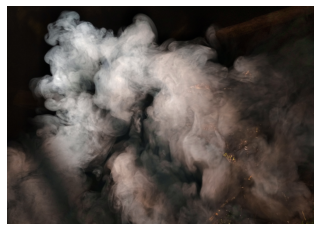

In [ ]:
from  matplotlib import pyplot as plt
import cv2

smoke = cv2.imread("/content/viktor-talashuk-Zcqw1XnVnDo-unsplash.jpg")
fire = cv2.imread("/content/fire.23.png")

smoke_resized = cv2.resize(smoke ,(fire.shape[0] * 2 , fire.shape[1] * 2 ))


plt.axis("off")
plt.imshow(cv2.cvtColor(smoke, cv2.COLOR_BGR2RGB))


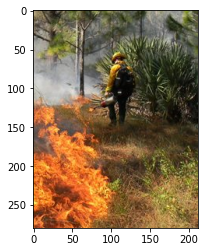

In [ ]:
plt.imshow(cv2.cvtColor(fire, cv2.COLOR_BGR2RGB))

In [ ]:
x , t , label  = patch_ex(ima_dest = fire, ima_src=smoke_resized, same=False, num_patches=1,
             mode=cv2.NORMAL_CLONE, width_bounds_pct=((0.3,0.7),(0.3,0.7)), min_object_pct=0.25, 
             min_overlap_pct=0.25, shift=False, label_mode='continuous', skip_background=None, tol=1, resize=True,
             gamma_params=None, intensity_logistic_params=(1/6, 20),
             resize_bounds=(0.7, 1.3), verbose=True)

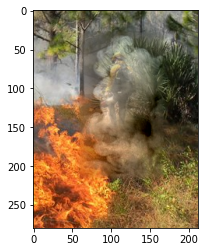

In [ ]:
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

In [ ]:
label

0.6254390647542225

In [ ]:
cv2.imwrite('./test.png',x)

True